# Demo - SLO Group 2

In [2]:
from get_all_metrics import get_metrics
import compile_benchmark_metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression

RANGE = list(range(1500, 5000, 500))
PERCENTILE = '99.9'
FILENAME = '../results/phase3_final_1000000ops_'
TH_RANGE = list(range(4, 35, 3))

# Get performance data for all load for a sigle threshold
def get_performance_for_threshold(threshold):
    data_list = []
    for load in RANGE:
        node_data = list(get_metrics(FILENAME+str(threshold)+"_" + str(load)))
        data = compile_benchmark_metrics.get_statistics(node_data)
        data_list.append((data, load))
    return data_list

def get_throughput_and_percentile(percentile, filename):
    file = open(filename, "r")
    lines = list(map(lambda line: line.rstrip('\n'), file.readlines()))
    
    latency_line = [line for line in lines if line.find("[READ], " + percentile) != -1][0]
    throughput_line = [line for line in lines if line.find("Throughput(ops/sec)") != -1][0]
    
    latency = latency_line.split()[-1]
    throughput = throughput_line.split()[-1]
    return latency, throughput

# Return tuple with the real throughput from ycsb and the latency from ycsb
def get_latency_tuple(load, threshold, filename_prefix = FILENAME):
    filename = filename_prefix + str(threshold) + "_" + str(load)
    latency, throughput = get_throughput_and_percentile(PERCENTILE, filename)
    return (float(throughput), int(latency))

# Get all the tuples
def get_latencies_for_threshold(threshold = 1, filename_prefix = FILENAME):
    return list(map(lambda load: get_latency_tuple(load, threshold, filename_prefix), RANGE))

# Get files for a threshold. 
# Both file with performance and latency and add them
def get_all_for_threshold(threshold):
    performance_data = get_performance_for_threshold(threshold)
    latency_data = get_latencies_for_threshold(threshold)
    
    return [(p, latency) for (p, (_th, latency)) in zip(performance_data, latency_data)]
    
# Do this for every threshold and make one list of them
def get_all_data():
    all_data = []
    for th in TH_RANGE:
        d = get_all_for_threshold(th)
        l = zip(d, [th] * len(d))
        all_data.extend(l)
    return all_data

## Reading Metrics and Performance

In [3]:
def print_all_for_threshold(threshold):
    print("Data when SR threshold = " + str(threshold) + ":")
    print()

    print("Load\t\tRead avg\tRead var\tWrite avg\tWrite var\t99.9th percentile latency")

    for (((r_avg, r_var, w_avg, w_var), load), latency) in get_all_for_threshold(threshold):
        print(str(load).ljust(16) + str(r_avg).ljust(16) + str(r_var).ljust(16) + str(w_avg).ljust(16) + str(w_var).ljust(16) + str(latency))

    print()
    print("Raw form:")
    print(get_all_for_threshold(threshold)[0])
    
print_all_for_threshold(TH_RANGE[0])

Data when SR threshold = 4:

Load		Read avg	Read var	Write avg	Write var	99.9th percentile latency
1500            367.125         26.796875       19.25           0.1875          34015
2000            488.25          44.6875         25.5            0.25            32719
2500            610.5           79.25           31.75           0.1875          32799
3000            732.25          104.6875        38.25           0.6875          34911
3500            856.75          169.6875        45.0            1.0             34655
4000            980.0           212.625         51.0            0.5             35263
4500            1100.75         207.1875        57.5            1.25            34463

Raw form:
(((367.125, 26.796875, 19.25, 0.1875), 1500), 34015)


## Show all benchmarks

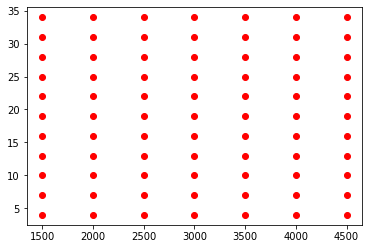

In [4]:
def distribution_between_x_and_y():
    data = get_all_data()
    x = []
    y = []
    w = []
    for ((((perf1, perf2, perf3, perf4), load), latency), sr) in data:
        x.append(sr)
        y.append(load)
    plt.scatter(y, x, color='r')
distribution_between_x_and_y()

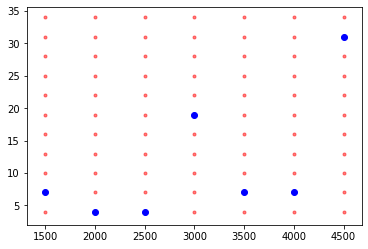

In [5]:
def get_minimums():
    data = get_all_data()

    minimums = []

    for r in RANGE:
        data_points = []
        for (((x, load), latency), threshold) in data:
            if(load == r):
                data_points.append((latency, threshold))

        (min_latency, min_threshold) = data_points[0]
        for (latency, threshold) in data_points:
            if(latency < min_latency):
                min_latency = latency
                min_threshold = threshold

        minimums.append((r, min_latency, min_threshold))
    return minimums

def distribution_between_x_and_y_with_best():
    data = get_all_data()
    x = []
    y = []
    w = []
    for ((((perf1, perf2, perf3, perf4), load), latency), sr) in data:
        x.append(sr)
        y.append(load)

        
    plt.scatter(y, x, color='r', alpha=0.5, marker='.')
    
    best_x = []
    best_y = []
    
    for (m_y, _w, m_x) in get_minimums():
        best_x.append(m_x)
        best_y.append(m_y)
    
    plt.scatter(best_y, best_x, color='b')
    
distribution_between_x_and_y_with_best()

## Weighted scaling

In [6]:
# Extract data and scale it
def get_scaled_data():
    data = [((x, x_target), y, weight) for (((x, x_target), weight), y) in get_all_data()]
    x, y, weight = zip(*itertools.chain(data))

    def weight_transformer(v):
        return (1 - v)**5

    # Scaling weights. MinMax gives 0 for the lowest and 1 for the highest. Linear
    # We apply the weight_transformer() to give higher weights to those elements that really matter.
    scaler = MinMaxScaler()
    scaler.fit(np.asarray(weight).reshape(-1, 1))
    s_weight = scaler.transform(np.asarray(weight).reshape(-1, 1))
    s_weight = [weight_transformer(e[0]) for e in s_weight]

    # Extracting the load vs target load
    x_target = [target for (_x, target) in x]
    x_load = [x for (x, _target) in x]
    
    return (x_load, x_target, y, s_weight)

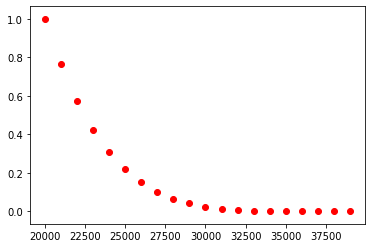

In [9]:
def plot_scaling_curve():
    y_range = list(range(20000, 40000, 1000))
    
    def weight_transformer(v):
            return (1 - v)**5

    # Scaling weights. MinMax gives 0 for the lowest and 1 for the highest. Linear
    # I apply the weight_transformer() to give higher weights to those elements that really matter.
    scaler = MinMaxScaler()
    scaler.fit(np.asarray(y_range).reshape(-1, 1))
    s_weight = scaler.transform(np.asarray(y_range).reshape(-1, 1))
    s_weight = [weight_transformer(e[0]) for e in s_weight]
    
    with open("scaling-points.csv", "w") as f:
        f.write("x, y\n")
        for x, y in zip(y_range, s_weight):
            f.write(str(x) + ", " + str(y) + "\n")
    
    plt.scatter(y_range, s_weight, color='r')
    
# We can see that values which has low latency are important (we want to predict that this is good)
# while the large values are not very important.
plot_scaling_curve()

### Heatmap

<img src="heatmap.png" alt="Heatmap" style="width:60%"/>

## Linear weighted regression

In [10]:
x, x_target, y, w = get_scaled_data()
model = LinearRegression()

reg = model.fit(np.asarray(x), np.asarray(y), sample_weight=np.asarray(w))

<!-- ![](regression-equation.png) -->

<img src="regression-equation.png" alt="Regression Equation" style="width:80%"/>

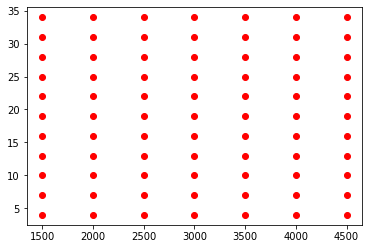

In [11]:
distribution_between_x_and_y()

Regression values:

Intercept	Read avg weight		Read var weight		Write avg weight	Write var weight
13.80302        -0.08933                0.046795                1.664629                -2.25407                



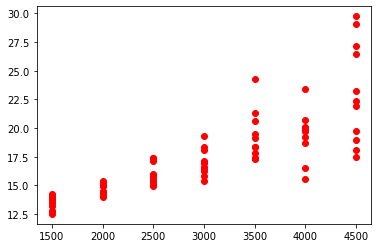

In [12]:
predictions = list(reg.predict(np.array(x)))
plt.scatter(x_target, predictions, color='r')


print("Regression values:")
print()

print("Intercept\tRead avg weight\t\tRead var weight\t\tWrite avg weight\tWrite var weight")

coeficients = list(map(lambda val: str(val)[:8].ljust(24) ,reg.coef_))

print(str(reg.intercept_)[:8].ljust(16) + coeficients[0] + coeficients[1] + coeficients[2] + coeficients[3])
print()